In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import sys, os
# Add the path to the utils directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from import_funcs import * #list_files_with_extension, extract_data_inline
from calibration_funcs import * 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from plotting_funcs import plot_all_conditions, plot_condition_classes
from sklearn.linear_model import LinearRegression



In [73]:
path = './data'
txt_files = list_files_with_extension(path, '.txt')

# Add a 'time_index' column before concatenating all_X
all_X = []

for i, file in enumerate(txt_files):
    file_idx = i
    file_name = file.split('_')[-1]
    # Extract data
    idx_start, idx_stop, delta_time, T, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['file_idx'] = file_idx
    X_local['file_name'] = file_name
    all_X.append(X_local)
    print(i, ':', file_name)

all_X = pd.concat(all_X, ignore_index=True)

all_X = all_X[all_X.file_name != "Manual Calibration Cable tau vs T cooling.txt"].reset_index(drop=True)
all_X["condition"] = ""
all_X.loc[all_X['file_name'] == "Manual Calibration Cable tau vs T.txt", "condition"] = "25"
all_X.loc[all_X['file_name'] == "Manual Calibration Cable tau vs T 50.txt", "condition"] = "50"

0 : Manual Calibration Cable tau vs T.txt
1 : Manual Calibration Cable tau vs T cooling.txt
2 : Manual Calibration Cable tau vs T.txt
3 : Manual Calibration Cable tau vs T 50.txt


In [74]:
all_X.loc[all_X['file_idx'] == 2, 'time_index'] += 2000

In [75]:
# Define calibration parameters as variables
RadSlopeChange = 0.0006182511106682944  # V/°C²
RadSlope0 = -0.06051481175395883        # V/°C
RadOffsetChange = -0.0009632383570051569 # V/°C
RadOffset0 = 0.2300154917793174         # V
HousingSlope = 98.08555780332561        # °C/V
HousingOffset = -49.81626782454236      # °C

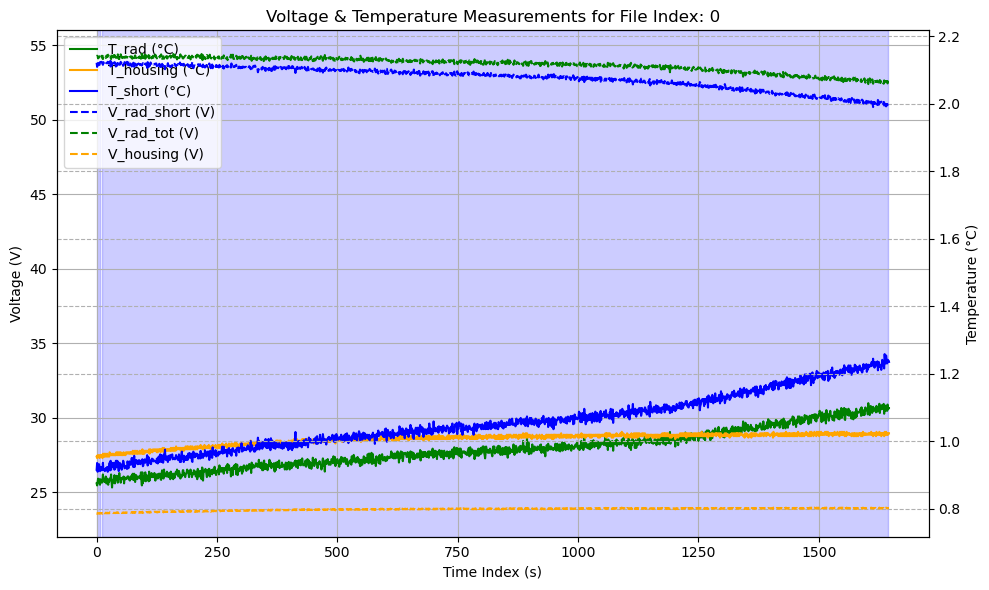

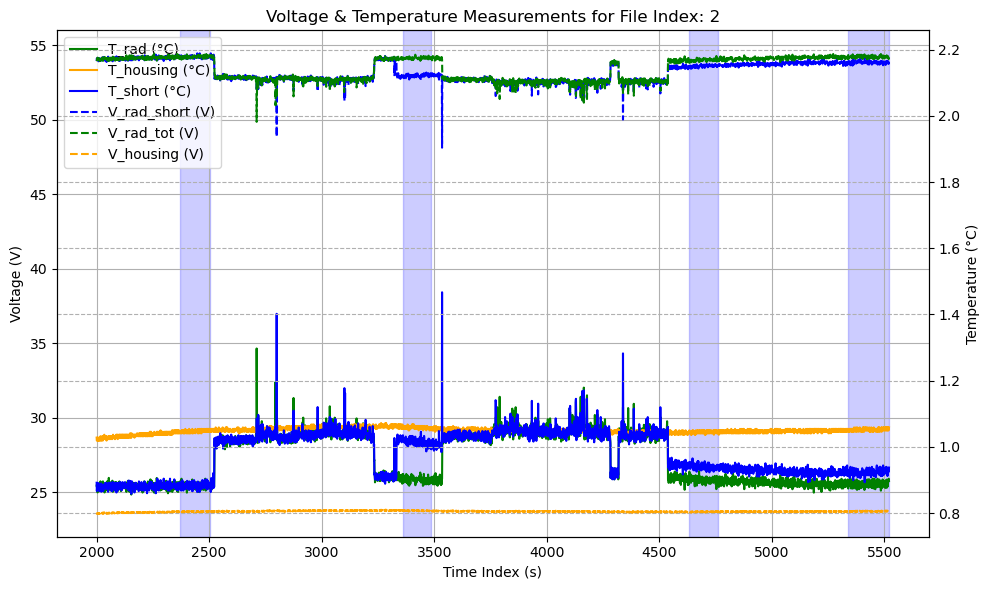

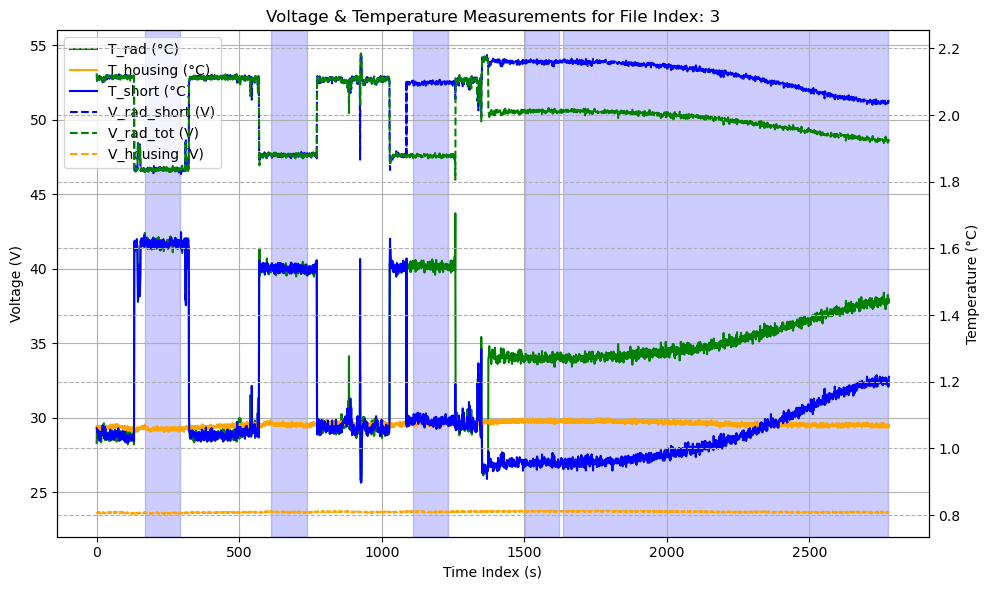

In [76]:
all_X["T_housing"] = T_housing_func(all_X["V_housing"]/1000, HousingSlope, HousingOffset)
all_X["T_rad"] = T_rad_func(all_X["V_rad_tot"]/1000, all_X["T_housing"], RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)
all_X["T_short"] = T_rad_func(all_X["V_rad_short"]/1000, all_X["T_housing"], RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)



variables_right = ['V_rad_short', 'V_rad_tot', 'V_housing',]
variables_left = ['T_rad', 'T_housing', 'T_short']
y_axes_right_lims = (None, None)
y_axes_left_lims = (22, 56)

variables_colors = {
    'V_rad_short': 'blue',
    'V_rad_tot': 'green',
    'V_housing': 'orange',
    'V_diode': 'red',
    'V_spike': 'purple',
    'T_housing': 'orange',
    'T_rad': 'green',
    'T_short': 'blue',
    'T_antenna': 'purple'
}
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)',
    'T_housing': 'T_housing (°C)',
    'T_rad': 'T_rad (°C)',
    'T_antenna': 'T_antenna (°C)',
    'T_short': 'T_short (°C)'
}

for idx in all_X['file_idx'].unique():
    subset = all_X[all_X['file_idx'] == idx]
    fig, ax1 = plt.subplots(figsize=(10, 6))
    for var in variables_left:
        ax1.plot(subset.time_index, subset[var] , label=labels[var], color=variables_colors[var])
    ax1.set_xlabel("Time Index (s)")
    ax1.set_ylabel("Voltage (V)")
    ax1.grid(True)
    ax1.set_ylim(y_axes_left_lims)

    ax2 = ax1.twinx()
    for var in variables_right:
        ax2.plot(subset.time_index, subset[var] / 1000, label=labels[var], linestyle='--', color=variables_colors[var])
    ax2.set_ylabel("Temperature (°C)")
    ax2.grid(True, linestyle='--')
    ax2.set_ylim(y_axes_right_lims)

    # Cooling periods shading
    cooling_periods = subset[subset['cooling_flag_1'] == 1]
    if not cooling_periods.empty:
        cooling_periods = cooling_periods.copy()
        cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
        for _, group in cooling_periods.groupby('group'):
            start = group['time_index'].min()
            end = group['time_index'].max()
            ax1.axvspan(start, end, color='blue', alpha=0.2)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title(f"Voltage & Temperature Measurements for File Index: {idx}")
    plt.tight_layout()
    plt.show()

In [77]:
# Assign 'class' labels for each condition separately
all_X['class'] = None

for cond in all_X['condition'].unique():
    cond_mask = all_X['condition'] == cond
    cond_df = all_X[cond_mask]
    cooling_periods = cond_df[cond_df['cooling_flag_1'] == 1].copy()
    cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
    periods = cooling_periods.groupby('group')['time_index'].agg(['first', 'last']).reset_index(drop=True)
    # Use labels list, repeat if needed
    labels_25 = ["**", "diplexer+cable+diode (heating)", "diplexer", "diplexer+diode", "diplexer+cable+diode", "*"]
    labels_50 = ["diplexer", "diplexer+diode*", "diplexer+diode", "diplexer+cable+diode", "diplexer+cable+diode (heating)"]
    if cond == "25":
        cond_labels = labels_25 * ((len(periods) + len(labels_25) - 1) // len(labels_25))
    elif cond == "50":
        cond_labels = labels_50 * ((len(periods) + len(labels_50) - 1) // len(labels_50))
    else:
        raise ImportError("Unknown condition")
    periods['label'] = cond_labels[:len(periods)]
    for _, row in periods.iterrows():
        mask = cond_mask & (all_X['time_index'] >= row['first']) & (all_X['time_index'] <= row['last'])
        all_X.loc[mask, 'class'] = row['label']

for cond in all_X['condition'].unique():
    print(f"\nCondition: {cond}")
    print(all_X[all_X['condition'] == cond]['class'].value_counts(dropna=False))



Condition: 25
class
None                              2953
diplexer+cable+diode (heating)    1632
*                                  184
diplexer                           137
diplexer+cable+diode               132
diplexer+diode                     124
**                                   7
Name: count, dtype: int64

Condition: 50
class
None                              1143
diplexer+cable+diode (heating)    1143
diplexer+diode*                    127
diplexer                           123
diplexer+diode                     122
diplexer+cable+diode               122
Name: count, dtype: int64


In [78]:
# Filter out classes with asterisks and get valid classes for each condition
all_X_clean = all_X[~all_X['class'].str.contains(r'\*', na=False)].copy()

# Remove rows where class is None
all_X_clean = all_X_clean[all_X_clean['class'].notna()].copy()

print("Valid classes by condition:")
conditions = sorted(all_X_clean['condition'].unique())

for cond in conditions:
    print(f"\nCondition: {cond}")
    print(all_X_clean[all_X_clean['condition'] == cond]['class'].value_counts())

Valid classes by condition:

Condition: 25
class
diplexer+cable+diode (heating)    1632
diplexer                           137
diplexer+cable+diode               132
diplexer+diode                     124
Name: count, dtype: int64

Condition: 50
class
diplexer+cable+diode (heating)    1143
diplexer                           123
diplexer+diode                     122
diplexer+cable+diode               122
Name: count, dtype: int64



Condition 25 - Data summary by class:
  diplexer: 137 points, time range: 0.0 - 136.0 s
  diplexer+diode: 124 points, time range: 157.0 - 280.0 s
  diplexer+cable+diode: 132 points, time range: 301.0 - 432.0 s
  diplexer+cable+diode (heating): 1632 points, time range: 453.0 - 2084.0 s

Condition 50 - Data summary by class:
  diplexer: 123 points, time range: 0.0 - 122.0 s
  diplexer+diode: 122 points, time range: 143.0 - 264.0 s
  diplexer+cable+diode: 122 points, time range: 285.0 - 406.0 s
  diplexer+cable+diode (heating): 1143 points, time range: 427.0 - 1569.0 s


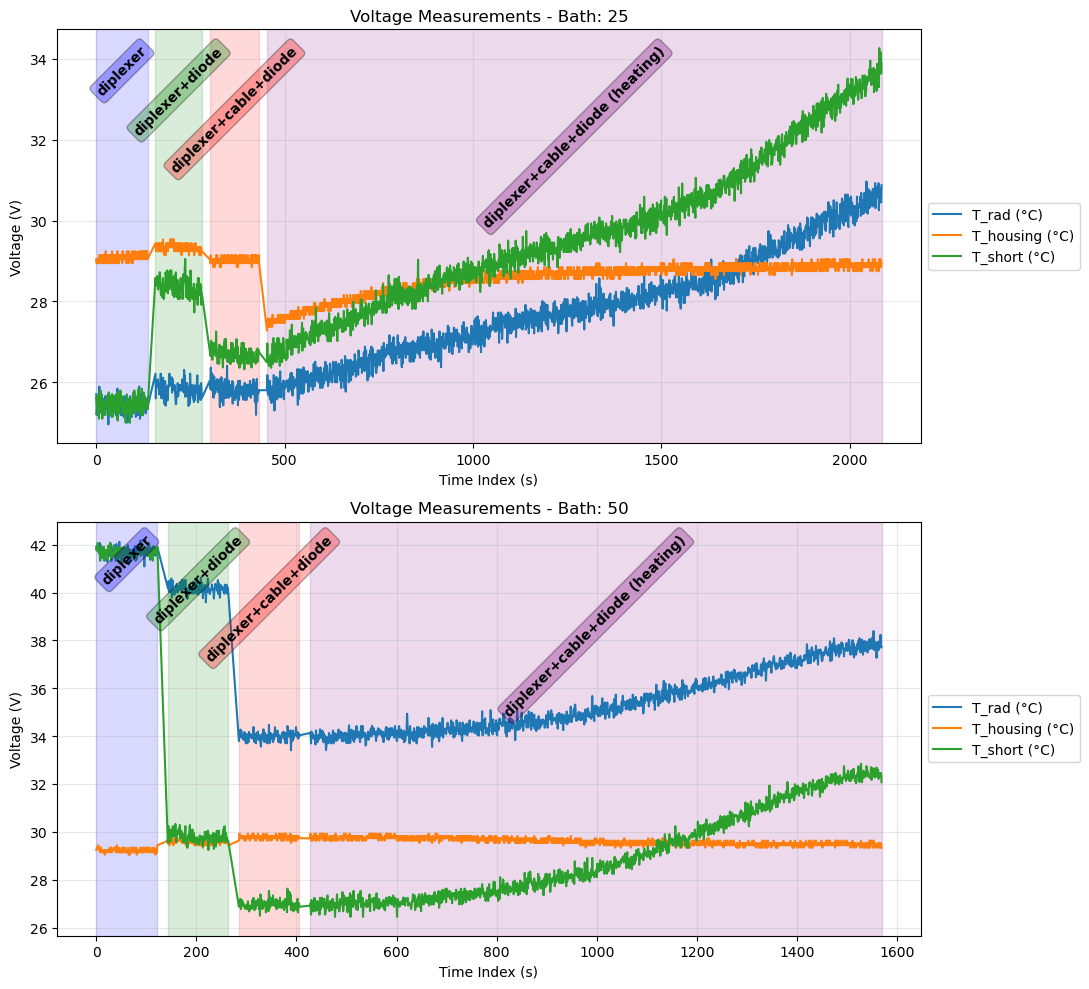

In [79]:
class_order = ["diplexer", "diplexer+diode", "diplexer+cable+diode", "diplexer+cable+diode (heating)"]
class_colors = {
    'diplexer': 'blue',
    'diplexer+diode': 'green',
    'diplexer+cable+diode': 'red',
    'diplexer+cable+diode (heating)': 'purple'
}
variables = ['T_rad', 'T_housing', 'T_short']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1,
    title_prefix="Voltage Measurements - Bath: ",
    ylabel="Voltage (V)"
)

In [83]:
# Calculate average V_rad_tot and V_housing for each condition and class
print("Average voltages by condition and class:")
print("="*50)

avg_values = {}

for condition in conditions:
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_values[condition] = condition_data.groupby('class')[['V_rad_tot', 'V_rad_short', 'V_housing', 'T_rad', 'T_housing', 'T_short']].mean()
    print("Microvolts:")
    print(avg_values[condition].round(1).to_string())
    print("-" * 30)

Average voltages by condition and class:

Condition: 25
Microvolts:
                                V_rad_tot  V_rad_short  V_housing  T_rad  T_housing  T_short
class                                                                                       
diplexer                           2178.8       2178.2      804.4   25.4       29.1     25.4
diplexer+cable+diode               2169.2       2150.3      803.7   25.8       29.0     26.7
diplexer+cable+diode (heating)     2115.6       2076.4      799.0   27.9       28.6     29.7
diplexer+diode                     2175.1       2121.1      807.0   25.8       29.3     28.4
------------------------------

Condition: 50
Microvolts:
                                V_rad_tot  V_rad_short  V_housing  T_rad  T_housing  T_short
class                                                                                       
diplexer                           1836.5       1836.6      805.9   41.7       29.2     41.7
diplexer+cable+diode               20

In [81]:
vna_excel_path = Path("/Users/mcy/Library/CloudStorage/OneDrive-HEPTAMEDICAL/HEPTA ADMIN - presentation_Manuel/VNA/VNA Measurements.xlsx")
vna_data = pd.read_excel(vna_excel_path)

date = "Aug 27 2025"
tau_cable = vna_data[(vna_data['DUT'] == 'Cable') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diplexer = vna_data[(vna_data['DUT'] == 'Diplexer') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diplexer_connector = vna_data[(vna_data['DUT'] == 'Diplexer + Connector') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diplexer_connector_cable = vna_data[(vna_data['DUT'] == 'Diplexer + Connector + Cable') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diode_bias_off = vna_data[(vna_data['DUT'] == 'Diode (no bias)') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diode_bias_positive = vna_data[(vna_data['DUT'] == 'Diode (bias positive)') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diode_bias_negative = vna_data[(vna_data['DUT'] == 'Diode (bias negative)') & (vna_data["Date"] == date)]['S21 (power)'].values[0]

print(f"Cable transmission: {tau_cable:.3f}")
print(f"Diplexer transmission: {tau_diplexer:.3f}")
print(f"Diplexer + Connector transmission: {tau_diplexer_connector:.3f}")
print(f"Diplexer + Connector + Cable transmission: {tau_diplexer_connector_cable:.3f}")
print(f"Diode (no bias) transmission: {tau_diode_bias_off:.3f}")
print(f"Diode (bias positive) transmission: {tau_diode_bias_positive:.3f}")
print(f"Diode (bias negative) transmission: {tau_diode_bias_negative:.3f}")

Cable transmission: 0.589
Diplexer transmission: 0.953
Diplexer + Connector transmission: 0.905
Diplexer + Connector + Cable transmission: 0.535
Diode (no bias) transmission: 0.845
Diode (bias positive) transmission: 0.003
Diode (bias negative) transmission: 0.849


# Calculate tau_D and T_D

In [88]:
T_diplexer = 26
tau_diplexer_hot_bath = (avg_values["50"].loc["diplexer", "T_rad"] - T_diplexer) / (50 - T_diplexer)
tau_diplexer_cold_bath = (avg_values["25"].loc["diplexer", "T_rad"] - T_diplexer) / (25 - T_diplexer)
delta_T_diplexer = 0
tau_diplexer_delta = (avg_values["50"].loc["diplexer", "T_rad"] - avg_values["25"].loc["diplexer", "T_rad"] - delta_T_diplexer) / (50 - 25 - delta_T_diplexer)
T_diplexer_hot = (avg_values["50"].loc["diplexer", "T_rad"] - tau_diplexer_delta * (50)) / (1 - tau_diplexer_delta)
T_diplexer_cold = T_diplexer_hot - delta_T_diplexer


print(tau_diplexer_hot_bath)
print(tau_diplexer_cold_bath)
print(tau_diplexer_delta)
print(T_diplexer_hot)
print(T_diplexer_cold)

0.6536850104479379
0.5792511144809254
0.6507076546092574
26.204575167681945
26.204575167681945


In [109]:
results = {}
for cond in ["25", "50"]:
    results[cond] = {}
    for _class in ['diplexer+diode', 'diplexer+cable+diode']:
        results[cond][_class] = {}
        T_rad=avg_values[cond].loc[_class, 'T_rad']
        T_short=avg_values[cond].loc[_class, 'T_short']
        T_housing=avg_values[cond].loc[_class, 'T_housing']
        T_bath=int(cond)
        print(f"Condition: {cond}, measure: {_class}")

        res = solve_tau_and_Tcable(
            T_rad=T_rad,
            T_short=T_short,
            T_housing=T_housing,
            T_bath=T_bath,
        )
        print(len(res))
        results[cond][_class] = res[0]
        results[cond][_class]['T_bath'] = T_bath
        results[cond][_class]['T_rad'] = T_rad
        results[cond][_class]['T_short'] = T_short
        results[cond][_class]['T_housing'] = T_housing
        for k, v in results[cond][_class].items():
            print(f"  {k}: {v}")
        print('-'*30)


Condition: 25, measure: diplexer+diode
1
  tau_T: 0.6766354154503659
  T_total: 27.572294790320353
  T_bath: 25
  T_rad: 25.83178903621113
  T_short: 28.3799667172134
  T_housing: 29.336404285052627
------------------------------
Condition: 25, measure: diplexer+cable+diode
1
  tau_T: 0.37941404408502694
  T_total: 26.31142532576689
  T_bath: 25
  T_rad: 25.81385213940215
  T_short: 26.701017225086
  T_housing: 29.0177700426578
------------------------------
Condition: 50, measure: diplexer+diode
1
  tau_T: 0.51174355415237
  T_total: 29.852123509039494
  T_bath: 50
  T_rad: 40.162669433146604
  T_short: 29.78232572650511
  T_housing: 29.585599177213723
------------------------------
Condition: 50, measure: diplexer+cable+diode
1
  tau_T: 0.31342429635859104
  T_total: 26.676498602502573
  T_bath: 50
  T_rad: 33.98665061663182
  T_short: 26.97996473740329
  T_housing: 29.765690693180485
------------------------------


In [113]:
_class = 'diplexer+diode'

def get_diplexer_tau_and_T(tau_T, T_total, tau_d, T_diode):
    tau_D = tau_T / (tau_d)
    T_diplexer = (
        T_total * (1-tau_T) 
        - T_diode * (1 - tau_d)
        ) / ((1 - tau_D)*tau_d)
    return tau_D, T_diplexer

for cond in ["25", "50"]:
    print(get_diplexer_tau_and_T(
        results[cond][_class]['tau_T'],
        results[cond][_class]['T_total'],
        0.85,
        27
    ))

(np.float64(0.7960416652357246), np.float64(28.067460621167864))
(np.float64(0.6020512401792589), np.float64(31.116899189171363))


# Calculate tau_C and T_C

In [114]:
_class = 'diplexer+cable+diode'

def get_cable_tau_and_Tcable(tau_T, T_total, tau_D, T_diplexer, tau_d, T_diode):
    tau_C = tau_T / (tau_D*tau_d)
    T_cable = (
        T_total * (1-tau_T) 
        - T_diplexer * tau_C * tau_d * (1-tau_D)
        - T_diode * (1 - tau_d)
        ) / ((1 - tau_C)*tau_d)
    return tau_C, T_cable

for cond in ["25", "50"]:
    print(get_cable_tau_and_Tcable(
        results[cond][_class]['tau_T'],
        results[cond][_class]['T_total'],
        0.70,
        27,
        0.88,
        25
    ))

(np.float64(0.6159318897484204), np.float64(26.445766591713575))
(np.float64(0.5088056759068036), np.float64(27.041392154486406))


In [134]:
_class = 'diplexer+cable+diode (heating)'
all_X_clean["tau_C"] = None
all_X_clean["T_cable"] = None
all_X_clean["tau_T"] = None
all_X_clean["T_total"] = None
all_X_clean["T_bath"] = all_X_clean["condition"].astype(float)
for cond in ["25", "50"]:
    data = all_X_clean[(all_X_clean["condition"] == cond) & (all_X_clean["class"] == _class)]
    data_idx = data.index
    for i, r in data.iterrows():
        res = solve_tau_and_Tcable(
            r["T_rad"],
            r["T_short"],
            r["T_housing"],
            r["T_bath"],
        )[0]
        all_X_clean.loc[i, "tau_T"] = res["tau_T"]
        print(all_X_clean.loc[i, "tau_T"])
        all_X_clean.loc[i, "T_total"] = res["T_total"]
        res_cable = get_cable_tau_and_Tcable(
            res["tau_T"],
            res["T_total"],
            0.70,
            27,
            0.88,
            25
        )
        all_X_clean.loc[i, "tau_C"] = res_cable[0]
        all_X_clean.loc[i, "T_cable"] = res_cable[1]




0.3999776785176688
0.36778286638346513
0.4350173385961981
0.45759678274306026
0.37730607032489094
0.43219770783048944
0.3477830092778366
0.3030219607360932
0.5263466878617894
0.5465120769681477
0.40294480494327833
0.4151111979964282
0.6029178103706458
0.4052926473322713
0.5399051202518724
0.4827343718150921
0.3433846180533806
0.5557519926270194
0.1922699530516127
0.4887027209350867
0.758133681802871
0.4749419355633927
0.4958183265681203
0.5028932948292127
0.6082977373107449
0.21939720398872065
0.5603489225024965
0.39875125809646494
0.5755484611671947
0.3746323847229792
0.5477825296543269
0.40827690328681737
0.6228679410855552
0.279858159595217
0.30494565515961747
0.29168430300667386
0.46915838911866525
0.4603610894949841
0.5093777249381042
0.4119598471297561
0.36530883686442756
0.4822157739371603
0.40192635190083864
0.5089687857154338
0.4373646861827114
0.6002604739120655
0.32595026939377425
0.3872827735302876
0.44553416633559106
0.3978848669962766
0.3967816767377387
0.3545727900528848


Condition 25 - Data summary by class:
  diplexer+cable+diode (heating): 1632 points, time range: 0.0 - 1631.0 s

Condition 50 - Data summary by class:
  diplexer+cable+diode (heating): 1143 points, time range: 0.0 - 1142.0 s


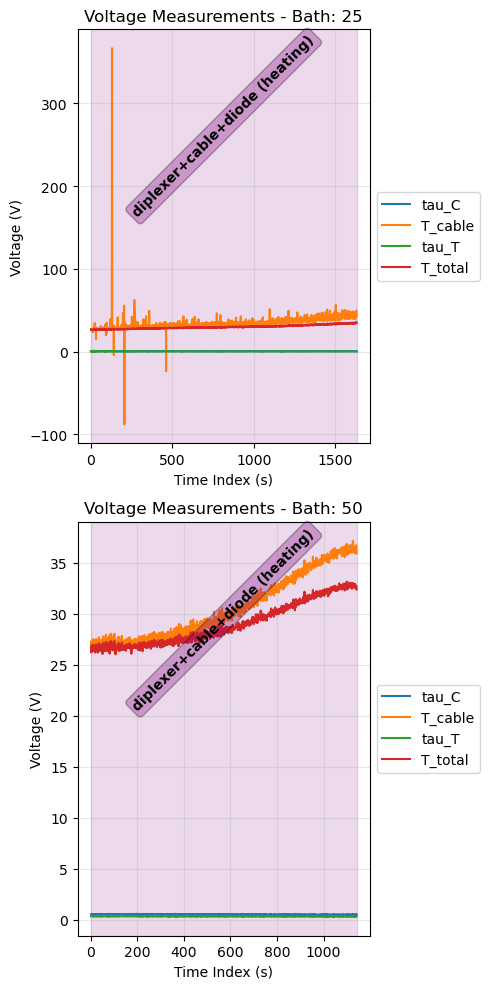

In [136]:
class_order = ["diplexer+cable+diode (heating)"]
class_colors = {
    'diplexer': 'blue',
    'diplexer+diode': 'green',
    'diplexer+cable+diode': 'red',
    'diplexer+cable+diode (heating)': 'purple'
}
variables = ['tau_C', 'T_cable', 'tau_T', 'T_total']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1,
    title_prefix="Voltage Measurements - Bath: ",
    ylabel="Voltage (V)"
)

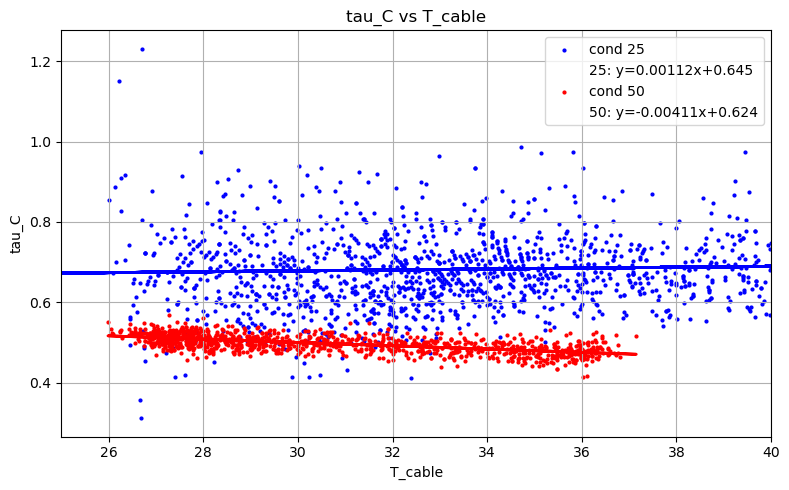

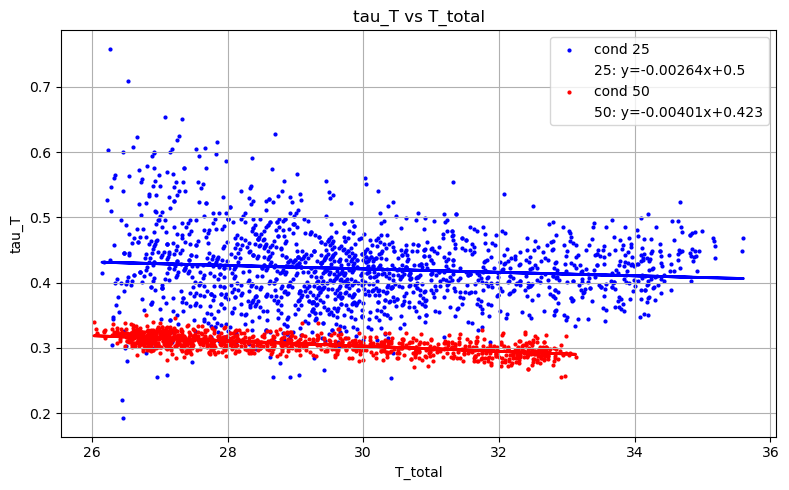

In [143]:
data_heating = all_X_clean[all_X_clean['class'] == 'diplexer+cable+diode (heating)'].copy()

fig, ax = plt.subplots(figsize=(8, 5))
for cond, color in zip(['25', '50'], ['blue', 'red']):
    subset = data_heating[data_heating['condition'] == cond]
    x = subset['T_cable'].astype(float)
    y = subset['tau_C'].astype(float)
    ax.scatter(x, y, label=f'cond {cond}', color=color, s=4)
    # Linear regression
    if len(x) > 1:
        lr = LinearRegression()
        lr.fit(x.values.reshape(-1, 1), y.values)
        y_pred = lr.predict(x.values.reshape(-1, 1))
        ax.plot(x, y_pred, color=color, linewidth=2)
        coef = lr.coef_[0]
        intercept = lr.intercept_
        ax.legend_.remove() if ax.legend_ else None
        ax.plot([], [], ' ', label=f'{cond}: y={coef:.3g}x+{intercept:.3g}')
ax.set_xlabel('T_cable')
ax.set_ylabel('tau_C')
ax.set_xlim([25, 40])
ax.legend()
ax.grid(True)
plt.title('tau_C vs T_cable')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
for cond, color in zip(['25', '50'], ['blue', 'red']):
    subset = data_heating[data_heating['condition'] == cond]
    x = subset['T_total'].astype(float)
    y = subset['tau_T'].astype(float)
    ax.scatter(x, y, label=f'cond {cond}', color=color, s=4)
    # Linear regression
    if len(x) > 1:
        lr = LinearRegression()
        lr.fit(x.values.reshape(-1, 1), y.values)
        y_pred = lr.predict(x.values.reshape(-1, 1))
        ax.plot(x, y_pred, color=color, linewidth=2)
        coef = lr.coef_[0]
        intercept = lr.intercept_
        ax.legend_.remove() if ax.legend_ else None
        ax.plot([], [], ' ', label=f'{cond}: y={coef:.3g}x+{intercept:.3g}')
ax.set_xlabel('T_total')
ax.set_ylabel('tau_T')
ax.legend()
ax.grid(True)
plt.title('tau_T vs T_total')
plt.tight_layout()
plt.show()